In [ ]:
# Testing it on Planet

In [ ]:
import rasterio

# Open the GeoTIFF file
with rasterio.open('20240721_222423_48_24f3_3B_Visual_clip_file_format.tif') as src:
    # Read all bands (or select bands as needed)
    image = src.read()  # shape: (channels, height, width)
    transform = src.transform  # Affine transformation matrix
    crs = src.crs  # Coordinate Reference System

# Extract pixel resolution from the transform:
pixel_width = transform.a        # pixel size in x direction
pixel_height = -transform.e      # pixel size in y (use absolute value)

print(pixel_width, pixel_height)

RasterioIOError: 20240721_222423_48_24f3_3B_Visual_clip_file_format.tif: No such file or directory

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import rasterio
import matplotlib.pyplot as plt

# Parameters
patch_size = 128
threshold = 0.5  # adjust based on your model's calibration

# 1. Load the GeoTIFF
with rasterio.open('20240721_222423_48_24f3_3B_Visual_clip_file_format.tif') as src:
    # Read all bands; shape: (channels, height, width)
    image = src.read()
    transform = src.transform

# 2. Preprocess the Image
# Remove the batch dimension (if any) and adjust channels.
# Assuming your model was trained on the first 3 channels, drop the 4th channel.
# image currently has shape (4, H, W); we convert to (H, W, 3)
image = image[0:3, :, :]             # shape now (3, H, W)
image = np.transpose(image, (1, 2, 0)) # now shape: (H, W, 3)
H, W, _ = image.shape

# (Optional) Normalize the image if required by your model
# For example, if pixel values are in [0, 255]:
image = image / 255.0

# 3. Load the Pre-trained Keras Model
model = load_model('2025-03-06_00-12-23.keras')

# 4. Patchify the Image and Run Inference
# We'll process the image in non-overlapping patches of size 128x128
n_h = H // patch_size  # number of patches along height
n_w = W // patch_size  # number of patches along width

# Pre-allocate an empty full-size mask
full_mask = np.zeros((H, W), dtype=np.uint8)

# Loop over patches, predict, and assemble the mask
for i in range(n_h):
    for j in range(n_w):
        # Extract patch
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]

        # Expand dimensions to create a batch of one image
        patch_input = np.expand_dims(patch, axis=0)  # shape: (1, 128, 128, 3)

        # Run inference on the patch
        patch_pred = model.predict(patch_input)
        patch_pred = np.squeeze(patch_pred)  # shape: (128, 128)

        # Convert prediction to binary mask using thresholding
        binary_patch = (patch_pred > threshold).astype(np.uint8)

        # Place the binary patch into the corresponding location in the full mask
        full_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = binary_patch

# 5. (Optional) Visualize a Portion of the Prediction
plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title("Predicted Lake Mask")
plt.axis('off')
plt.show()

In [ ]:
full_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

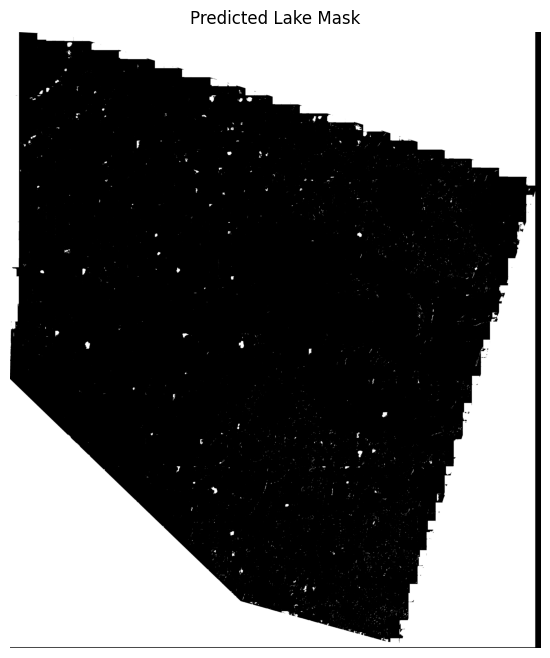

In [ ]:
# 5. (Optional) Visualize a Portion of the Prediction
plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title("Predicted Lake Mask")
plt.axis('off')
plt.show()

In [ ]:
binary_mask = full_mask
# Compute area per pixel (in square meters, if dimensions are in meters)
pixel_area = pixel_width * pixel_height

# Count the lake pixels
lake_pixel_count = np.sum(binary_mask)

# Compute the total lake area
total_lake_area = lake_pixel_count * pixel_area
print("Total lake area:", total_lake_area, "square meters")

Total lake area: 203844951.0 square meters


In [ ]:

from skimage.measure import label, regionprops

# Label connected regions in the binary mask (each region represents a separate lake)
labeled_mask = label(binary_mask)

# Get region properties for each lake
regions = regionprops(labeled_mask)

# Calculate and print area for each lake
for region in regions:
    lake_area = region.area * pixel_area
    print(f"Lake ID: {region.label}, Area: {lake_area:.2f} square meters")

Streaming output truncated to the last 5000 lines.
Lake ID: 1953, Area: 9.00 square meters
Lake ID: 1954, Area: 279.00 square meters
Lake ID: 1955, Area: 9.00 square meters
Lake ID: 1956, Area: 9.00 square meters
Lake ID: 1957, Area: 9.00 square meters
Lake ID: 1958, Area: 18.00 square meters
Lake ID: 1959, Area: 9.00 square meters
Lake ID: 1960, Area: 45.00 square meters
Lake ID: 1961, Area: 27.00 square meters
Lake ID: 1962, Area: 9.00 square meters
Lake ID: 1963, Area: 54.00 square meters
Lake ID: 1964, Area: 18.00 square meters
Lake ID: 1965, Area: 9.00 square meters
Lake ID: 1966, Area: 9.00 square meters
Lake ID: 1967, Area: 54.00 square meters
Lake ID: 1968, Area: 9.00 square meters
Lake ID: 1969, Area: 54.00 square meters
Lake ID: 1970, Area: 27.00 square meters
Lake ID: 1971, Area: 18.00 square meters
Lake ID: 1972, Area: 9.00 square meters
Lake ID: 1973, Area: 2151.00 square meters
Lake ID: 1974, Area: 18.00 square meters
Lake ID: 1975, Area: 63.00 square meters
Lake ID: 1976

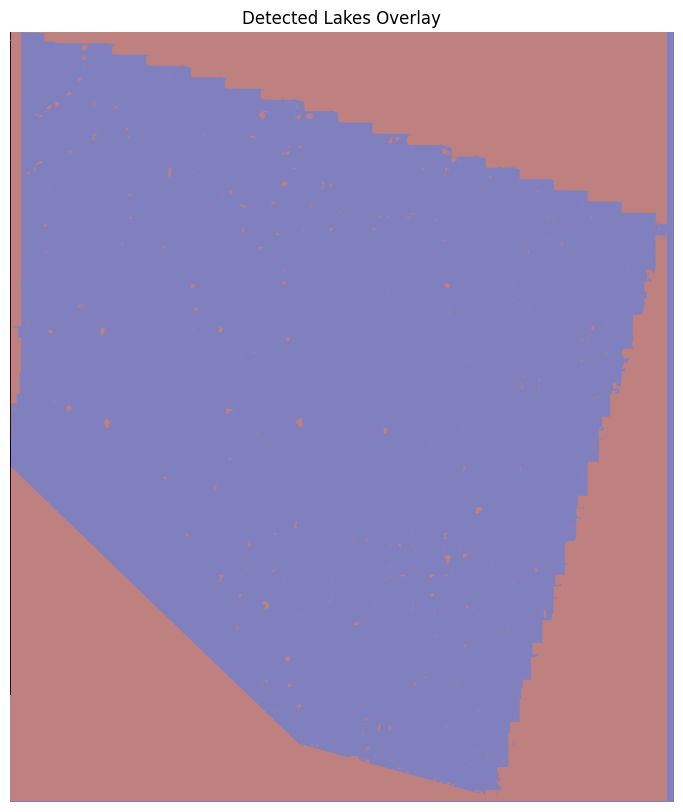

In [ ]:
import matplotlib.pyplot as plt

# Display the first band of the original image with the detected lake mask overlaid
plt.figure(figsize=(10, 10))
plt.imshow(image[0], cmap='gray')  # using the first band for visualization
plt.imshow(binary_mask, cmap='jet', alpha=0.5)  # overlay the mask with transparency
plt.title("Detected Lakes Overlay")
plt.axis('off')
plt.show()

In [ ]:
crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 3N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-165],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32603"]]')

In [ ]:
import rasterio

# Assuming you already have:
# - full_mask: a numpy array with shape (H, W)
# - transform: the affine transform extracted from your original GeoTIFF
# - crs: the coordinate reference system from your original GeoTIFF

output_filename = 'predicted_lake_mask.tif'

with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=full_mask.shape[0],
    width=full_mask.shape[1],
    count=1,  # one band for the binary mask
    dtype=full_mask.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(full_mask, 1)  # Write the mask to band 1

print("GeoTIFF saved as:", output_filename)

GeoTIFF saved as: predicted_lake_mask.tif
